In [45]:
#autoreload
%load_ext autoreload

%autoreload 2

import sys
sys.path.append('../')
import torch
import numpy as np

import dataset
import json

from pl_model import SegmentadorMonoclase
import os
from glob import glob
import matplotlib.pyplot as plt
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# json_normalizacion="../modelos/normalization_rayosX.json"
# # Read json normalization file
# with open(json_normalizacion, 'r') as file:
#     normalizacion = json.load(file)


# media= normalizacion["medias_norm"]
# dstd= normalizacion["stds_norm"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [47]:
# def normalizacion_imagen(imgtensor,normalizacion):
#     media=torch.tensor(normalizacion['medias_norm']).unsqueeze(1).unsqueeze(2)
#     dstd=torch.tensor(normalizacion['stds_norm']).unsqueeze(1).unsqueeze(2)
#     imgnormalizado =(imgtensor-media)
#     return imgnormalizado

def predict_image(imgname,modelo,device):
    if isinstance(imgname,str):
        imgtensor = dataset.read_image_rayosX(imgname,2**16-1)
    else:
        imgtensor=imgname
    
    imgnormalizado=imgtensor # torch.log(imgtensor)/math.log(0.2)
    imgnormalizado=imgnormalizado.unsqueeze(0).to(device)
   
    modelo.eval()
    with torch.no_grad():
         logits = modelo(imgnormalizado)
    logits= logits[0,0,:,:]
    probs=torch.nn.functional.sigmoid(logits)
    probs=probs.cpu().numpy()         
    return probs

In [48]:
modelo= SegmentadorMonoclase(
                            optimizer = 'sgd',  
                            num_channels_in=3,
                            model_version="deeplabv3_resnet50",
                          )
fichmodelo="../out_models/segmentadorRayosX.ckpt"
checkpoint = torch.load(fichmodelo)
modelo.load_state_dict(checkpoint['state_dict'])
modelo.eval()
_=modelo.to(device)


SegmentadorMonoclase Num epochs: None
MODEL NUM CHHANELS IN 3
DeepLab Num channels_in: 3


In [49]:
usuario=os.getenv('USER')
home=os.getenv('HOME')
mscanData= home + '/owc/mscanData/' if usuario == 'aalbiol' else home + 'mscanData/'
# /home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales
dir_recortes_in=os.path.join(mscanData , 'rayosX/reales2/recortes_reales')
print(dir_recortes_in)
input_files=glob(os.path.join(dir_recortes_in , '*.png'))
print('Number of input files:', len(input_files))   
print('First file:', input_files[0])

/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales
Number of input files: 153
First file: /home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00135.png


In [50]:
root_folder="/home/aalbiol/owc/mscanData/rayosX/pollo"
train_dataset=("../listas_rayosX/buenos/train/train_list.txt","recortes_good")

params={
    'prob_no_change':0.0,
    'min_number_of_defects':1,
    'max_number_of_defects':3,
    'alpha_low': 0.04,
    'alpha_high': 0.02,
    'min_defect_size':40,
    'max_defect_size':150,
    'min_defect_width':2,
    'max_defect_width':5,
    'defect_types':{'FlatLine': 1.0, 'CylLine': 1.0, 'FlatSpline': 1.0, 'CylSpline':1.0}
    }

ds=dataset.DataplacesDataSetSimulaDefectos(root_folder=root_folder,dataplaces=[train_dataset], 
                             max_values=[2**16-1,2**16-1,2**16-1],delimiter=".",terminaciones=[".png"],
                             params_simulacion_defectos=params,transform=None,scale=1.0)

>>>>>>>>>>>> DataplacesDataset terminaciones ['.png'] delimiter .
>>>>>>>>>> scale in DataSet 1.0
Datos de normalizacion calculados y guardados en modelos/normalization.json


['/home/aalbiol/owc/mscanData/rayosX/pollo/recortes_good/LOWentremusloGood_00085.png']


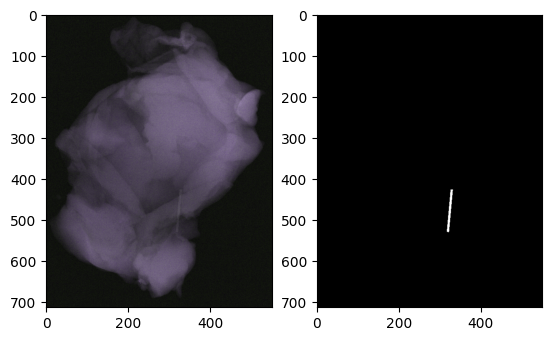

In [51]:
im,nombre,mask=ds.__getitem__(0)
print(nombre)
_=plt.subplot(1,2,1)
_=plt.imshow(im.permute((1,2,0)).numpy(),cmap="gray",clim=[0,1])
_=plt.subplot(1,2,2)
_=plt.imshow(mask.numpy(),cmap="gray",clim=[0,1])


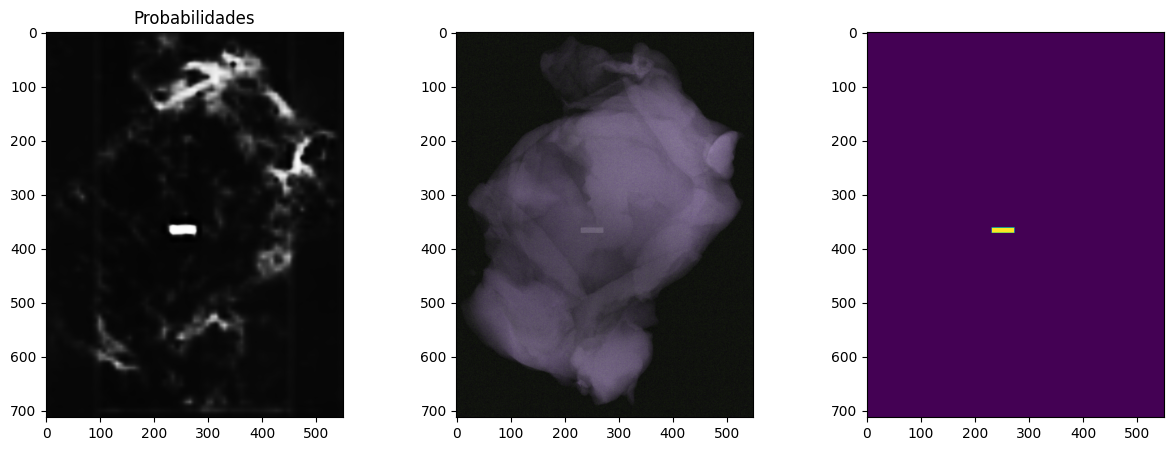

In [53]:
k=0
im,nombre,mask=ds.__getitem__(k)
probs=predict_image(im,modelo,device)
_=plt.figure(figsize=(15,5))
_=plt.subplot(1,3,1)
_=plt.imshow(probs,clim=(0,1),cmap='gray')
_=plt.title('Probabilidades')
_=plt.subplot(1,3,2)
plt.imshow(im.permute((1,2,0)).numpy())
_=plt.subplot(1,3,3)
plt.imshow(mask.numpy())


In [59]:
condefectos =[f for f in input_files if "0020" in f]
condefectos += [f for f in input_files if "0021" in f]
condefectos += [f for f in input_files if "0022" in f]
condefectos += [f for f in input_files if "0023" in f]
condefectos+=[f for f in input_files if "0024" in f]
condefectos+=[f for f in input_files if "0025" in f]
condefectos+=[f for f in input_files if "0026" in f]
condefectos +=[f for f in input_files if "0027" in f]
condefectos +=[f for f in input_files if "0028" in f]
print(condefectos)

['/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00020.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00021.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00022.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00023.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00024.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00025.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00026.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00027.png', '/home/aalbiol/owc/mscanData/rayosX/reales2/recortes_reales/LOWImg_20240923_083508_00028.png']


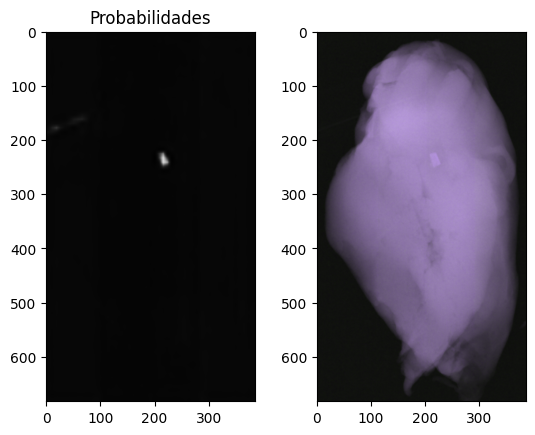

In [70]:
k=8
imgtensor=torch.log(dataset.read_image_rayosX(condefectos[k],2**16-1))/math.log(.2)
probs=predict_image(imgtensor,modelo,device)
_=plt.subplot(1,2,1)
_=plt.imshow(probs,clim=(0,1),cmap='gray')
_=plt.title('Probabilidades')
_=plt.subplot(1,2,2)
img= plt.imshow(imgtensor.permute((1,2,0)).detach().cpu().numpy())

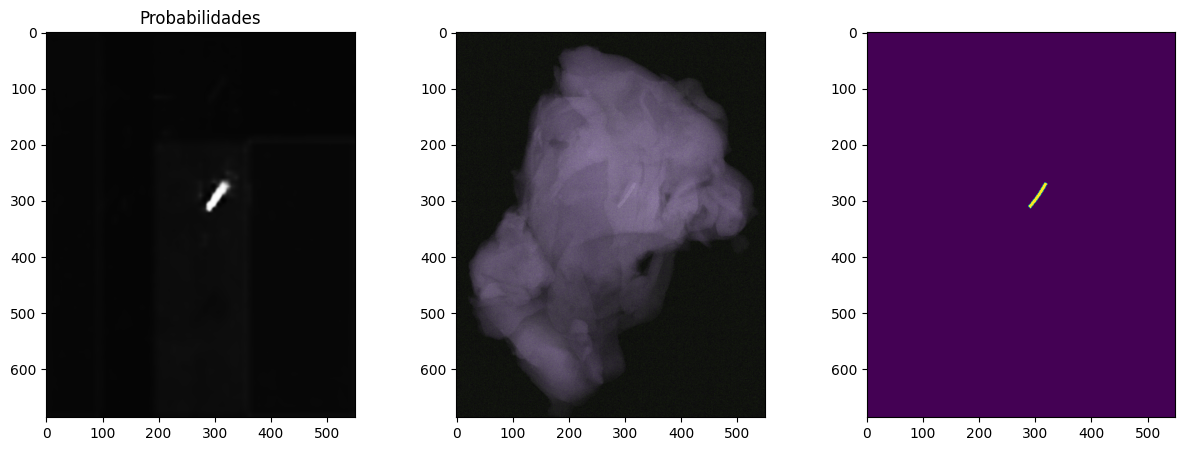

In [22]:
k=41
im,nombre,mask=ds.__getitem__(k)
probs=predict_image(im,modelo,device)
_=plt.figure(figsize=(15,5))
_=plt.subplot(1,3,1)
_=plt.imshow(probs,clim=(0,1),cmap='gray')
_=plt.title('Probabilidades')
_=plt.subplot(1,3,2)
plt.imshow(im.permute((1,2,0)).numpy())
_=plt.subplot(1,3,3)
plt.imshow(mask.numpy())



# Defectos reales

In [13]:
dir_recortes_in=mscanData + 'rayosX/pollo_real/recortes_reales/'
input_files=glob(dir_recortes_in + 'LOW*.png')
input_files.sort()
print('Number of input files:', len(input_files))   
print('First file:', input_files[0])

Number of input files: 38
First file: /home/aalbiol/owc/mscanData/rayosX/pollo_real/recortes_reales/LOWImg_20240918_144028_00001.png


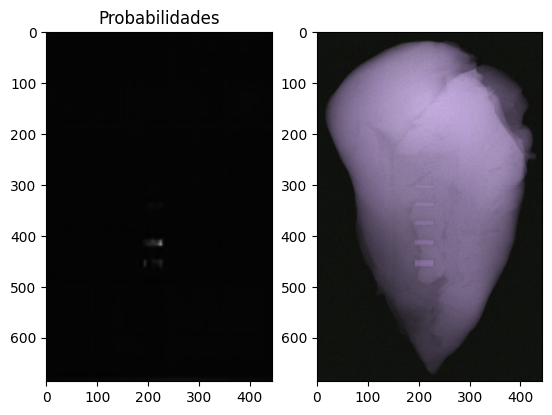

In [18]:
k=20
imgtensor=torch.log(dataset.read_image_rayosX(input_files[k],2**16-1))/math.log(.2)
probs=predict_image(imgtensor,normalizacion,modelo,device)
_=plt.subplot(1,2,1)
_=plt.imshow(probs,clim=(0,1),cmap='gray')
_=plt.title('Probabilidades')
_=plt.subplot(1,2,2)
img= plt.imshow(imgtensor.permute((1,2,0)).detach().cpu().numpy())